In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# import lightgbm as lgb



In [2]:
# Load datasets

# Train Data
temp_df = pd.read_csv("/content/train.csv", nrows=0)  # Read only the header
total_columns = len(temp_df.columns)
columns_to_use = temp_df.columns[1:total_columns]
train_data = pd.read_csv("/content/train.csv", usecols=columns_to_use)

# Test Data
test_data = pd.read_csv("/content/test.csv", usecols=columns_to_use)

# Dropping the columns that are not relevant to our analysis
train_data = train_data.drop(columns=['building_name', 'site_name','date'])
test_data = test_data.drop(columns=['building_name', 'site_name','date'])



train_data = train_data[(train_data['meter'] == 'electricity') | (train_data['meter'] == 'chilledwater')
| (train_data['meter'] == 'hotwater') | (train_data['meter'] == 'gas')]

test_data = test_data[(test_data['meter'] == 'electricity') | (test_data['meter'] == 'chilledwater')
| (test_data['meter'] == 'hotwater') | (test_data['meter'] == 'gas')]


# Building index on building_id for furhter assessment
train_data.set_index('building_id', inplace=True)
test_data.set_index('building_id', inplace=True)

In [3]:
# Inspecting the data frames
print(train_data.sample(2))
print('-------------------------------------------------------------')
print(test_data.sample(2))

                    meter  meter_reading sub_primaryspaceusage      sqm  \
building_id                                                               
279          chilledwater      5924.6316     College Classroom   4559.5   
140          chilledwater     52526.7762     College Classroom  20071.7   

                 sqft     timezone  airTemperature  cloudCoverage  \
building_id                                                         
279           49078.0  US/Mountain       10.475877       1.930225   
140          216050.0   US/Central       20.687500       1.980992   

             dewTemperature  precipDepth1HR  precipDepth6HR  seaLvlPressure  \
building_id                                                                   
279                2.050877        0.380880       12.085381     1014.273334   
140               14.643202        1.491614       17.853595     1012.253741   

             windDirection  windSpeed  season  site_id  
building_id                                     

In [4]:
# Separating into X and Y dataframes
X_train = train_data.drop(columns=['meter_reading'])  # Exclude target variable
y_train = train_data['meter_reading']

X_test = test_data.drop(columns=['meter_reading'])  # Exclude target variable
y_test = test_data['meter_reading']

In [5]:
# Convert 'site_id' from numeric to categorical
X_train['site_id'] = X_train['site_id'].astype('category')
X_test['site_id'] = X_test['site_id'].astype('category')

In [6]:
print(X_train.dtypes)
print(X_train.columns)

meter                      object
sub_primaryspaceusage      object
sqm                       float64
sqft                      float64
timezone                   object
airTemperature            float64
cloudCoverage             float64
dewTemperature            float64
precipDepth1HR            float64
precipDepth6HR            float64
seaLvlPressure            float64
windDirection             float64
windSpeed                 float64
season                     object
site_id                  category
dtype: object
Index(['meter', 'sub_primaryspaceusage', 'sqm', 'sqft', 'timezone',
       'airTemperature', 'cloudCoverage', 'dewTemperature', 'precipDepth1HR',
       'precipDepth6HR', 'seaLvlPressure', 'windDirection', 'windSpeed',
       'season', 'site_id'],
      dtype='object')


In [7]:
# Define features and types based on your dataset
numerical_features = ['sqm', 'sqft', 'airTemperature', 'cloudCoverage', 'dewTemperature',
                      'precipDepth1HR', 'precipDepth6HR', 'seaLvlPressure', 'windDirection', 'windSpeed']
categorical_features = ['timezone', 'season', 'sub_primaryspaceusage', 'site_id']

In [8]:
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [9]:
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit the preprocessor on the training data and transform both training and test data
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [10]:
# Convert the processed data back to dense DataFrames
X_train_processed_df = pd.DataFrame(X_train_processed.toarray(), columns=preprocessor.get_feature_names_out())
X_test_processed_df = pd.DataFrame(X_test_processed.toarray(), columns=preprocessor.get_feature_names_out())

In [11]:
# Checking the columns
X_train_processed_df.columns

Index(['num__sqm', 'num__sqft', 'num__airTemperature', 'num__cloudCoverage',
       'num__dewTemperature', 'num__precipDepth1HR', 'num__precipDepth6HR',
       'num__seaLvlPressure', 'num__windDirection', 'num__windSpeed',
       'cat__timezone_Europe/Dublin', 'cat__timezone_Europe/London',
       'cat__timezone_US/Central', 'cat__timezone_US/Eastern',
       'cat__timezone_US/Mountain', 'cat__timezone_US/Pacific',
       'cat__season_Fall', 'cat__season_Spring', 'cat__season_Summer',
       'cat__season_Winter', 'cat__sub_primaryspaceusage_Academic',
       'cat__sub_primaryspaceusage_Auditorium',
       'cat__sub_primaryspaceusage_Classroom',
       'cat__sub_primaryspaceusage_College Classroom',
       'cat__sub_primaryspaceusage_College Laboratory',
       'cat__sub_primaryspaceusage_Education',
       'cat__sub_primaryspaceusage_K-12 School',
       'cat__sub_primaryspaceusage_Other - Education',
       'cat__sub_primaryspaceusage_Primary/Secondary Classroom',
       'cat__sub_pri

In [12]:
scaler = MinMaxScaler()

# Fit scaler on the training set
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

# Only transform the test set, do not fit the scaler to it to avoid data leakage
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

## LightGBM

### Light GBM for all meter values with hyperparameter tuning

In [13]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [20, 31, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.8, 0.9],
}


unique_meters = train_data['meter'].unique()
results = []

for meter_value in unique_meters:
    print(f"Processing meter value: {meter_value}")

    # Splitting data for the specific meter value
    X = train_data[train_data['meter'] == meter_value].drop(columns=['meter_reading', 'meter'])
    y = train_data[train_data['meter'] == meter_value]['meter_reading']

    # Convert 'site_id' from numeric to categorical
    X['site_id'] = X['site_id'].astype('category')

    # Splitting data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and apply preprocessing pipeline
    preprocessor = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Scale the target variable
    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1))
    y_test_scaled = y_scaler.transform(np.array(y_test).reshape(-1, 1))

    # Preparing dataset for LightGBM
    model = LGBMRegressor(boosting_type='gbdt', force_col_wise=True)

    # Set up GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

    # Fit the grid search to the data
    grid.fit(X_train_processed, y_train_scaled.flatten())

    # Get the best parameters
    best_params = grid.best_params_

    # Train a final model with the best parameters
    final_model = LGBMRegressor(boosting_type='rf', force_col_wise=True, **best_params)
    final_model.fit(X_train_processed, y_train_scaled.flatten())

    # Model prediction and evaluation
    y_pred_scaled = final_model.predict(X_test_processed)
    rsquared = r2_score(y_test_scaled, y_pred_scaled)


    results.append({
        'meter_value': meter_value,
        'best_params': best_params,
        'r-squared': rsquared
    })

# Convert results to a DataFrame and print
results_df = pd.DataFrame(results)
print(results_df)

Processing meter value: electricity
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 117900, number of used features: 48
[LightGBM] [Info] Start training from score 0.023886
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 117901, number of used features: 48
[LightGBM] [Info] Start training fr

In [14]:
import ast

results_df['best_params'] = results_df['best_params'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert the DataFrame to a dictionary where keys are meter values and values are the best parameter sets
best_params_dict = pd.Series(results_df.best_params.values, index=results_df.meter_value).to_dict()

results = []
for meter_value in unique_meters:
    print(f"Fitting model for meter type: {meter_value}")

    # Filtering and preprocessing the training data
    X_train = train_data[train_data['meter'] == meter_value].drop(columns=['meter_reading', 'meter'])
    y_train = train_data[train_data['meter'] == meter_value]['meter_reading']
    X_train['site_id'] = X_train['site_id'].astype('category')  # Convert 'site_id' to categorical

    # Apply the same preprocessing as before
    X_train_processed = preprocessor.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1))

    # Filtering and preprocessing the test data
    X_test = test_data[test_data['meter'] == meter_value]
    X_test['site_id'] = X_test['site_id'].astype('category')  # Convert 'site_id' to categorical
    X_test_processed = preprocessor.transform(X_test)

    # Define and train the final model using the best parameters found for this meter type
    best_params = best_params_dict[meter_value]  # Retrieve best parameters for the current meter type
    final_model = LGBMRegressor(boosting_type='rf', force_col_wise=True, **best_params)
    final_model.fit(X_train_processed, y_train_scaled.flatten())

    # Predict on the test dataset
    y_pred_scaled = final_model.predict(X_test_processed)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))  # Convert predictions back to original scale

    results.append({
        'meter_value': meter_value,
        'predictions': y_pred.flatten()
    })


Fitting model for meter type: electricity


<ipython-input-14-45f5aab4f787>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['site_id'] = X_test['site_id'].astype('category')  # Convert 'site_id' to categorical


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2595
[LightGBM] [Info] Number of data points in the train set: 221064, number of used features: 48
[LightGBM] [Info] Start training from score 0.023762
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Fitting model for meter type: chilledwater


<ipython-input-14-45f5aab4f787>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['site_id'] = X_test['site_id'].astype('category')  # Convert 'site_id' to categorical


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2556
[LightGBM] [Info] Number of data points in the train set: 85644, number of used features: 36
[LightGBM] [Info] Start training from score 0.006903
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Fitting model for meter type: gas


<ipython-input-14-45f5aab4f787>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['site_id'] = X_test['site_id'].astype('category')  # Convert 'site_id' to categorical


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2274
[LightGBM] [Info] Number of data points in the train set: 36600, number of used features: 27
[LightGBM] [Info] Start training from score 0.020306
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Fitting model for meter type: hotwater


<ipython-input-14-45f5aab4f787>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['site_id'] = X_test['site_id'].astype('category')  # Convert 'site_id' to categorical


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Total Bins 2244
[LightGBM] [Info] Number of data points in the train set: 29646, number of used features: 31
[LightGBM] [Info] Start training from score 0.016716
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


In [15]:
from sklearn.metrics import mean_squared_error, r2_score

# Ensure results is a list containing dictionaries with 'meter_value' and 'predictions'
updated_results = []  # This will store the extended results including the new metrics

for result in results:
    meter_value = result['meter_value']
    predictions = result['predictions']

    # Extract the actual values from the test data
    y_true = test_data[test_data['meter'] == meter_value]['meter_reading'].values  # Ensure this column name matches your actual data

    # Check if y_true and predictions have the same length
    if len(predictions) != len(y_true):
        print(f"Error: Mismatched number of predictions and true values for meter {meter_value}")
        continue  # Skip to the next loop iteration

    # Calculate metrics
    mse = mean_squared_error(y_true, predictions)
    r_squared = r2_score(y_true, predictions)
    negative_mse = -mse

    # Update the results with the new metrics
    updated_results.append({
        'meter_value': meter_value,
        'mse': mse,
        'r_squared': r_squared,
        'negative_mse': negative_mse
    })

# Convert updated results to a DataFrame and print
updated_results_df = pd.DataFrame(updated_results)
print(updated_results_df)


    meter_value           mse  r_squared  negative_mse
0   electricity  9.503506e+06   0.818345 -9.503506e+06
1  chilledwater  1.409652e+13   0.725804 -1.409652e+13
2           gas  7.274804e+08   0.726157 -7.274804e+08
3      hotwater  2.266721e+12   0.601367 -2.266721e+12


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

# Ensure results is a list containing dictionaries with 'meter_value' and 'predictions'
updated_results = []  # This will store the extended results including the new metrics
predictions_dict = {}  # Dictionary to store predictions for each meter

for result in results:
    meter_value = result['meter_value']
    predictions = result['predictions']

    # Extract the actual values from the test data
    y_true = test_data[test_data['meter'] == meter_value]['meter_reading'].values  # Ensure this column name matches your actual data

    # Check if y_true and predictions have the same length
    if len(predictions) != len(y_true):
        print(f"Error: Mismatched number of predictions and true values for meter {meter_value}")
        continue  # Skip to the next loop iteration

    # Calculate metrics
    mse = mean_squared_error(y_true, predictions)
    r_squared = r2_score(y_true, predictions)
    negative_mse = -mse

    # Update the results with the new metrics
    updated_results.append({
        'meter_value': meter_value,
        'mse': mse,
        'r_squared': r_squared,
        'negative_mse': negative_mse
    })

    # Store predictions for each meter
    predictions_dict[meter_value] = predictions

# Convert updated results to a DataFrame and print
updated_results_df = pd.DataFrame(updated_results)
print(updated_results_df)

# Save predictions for each meter in a separate dictionary
for meter_value, predictions in predictions_dict.items():
    # Do whatever you want with the predictions
    print(f"Meter value: {meter_value}, Predictions: {predictions}")


    meter_value           mse  r_squared  negative_mse
0   electricity  9.503506e+06   0.818345 -9.503506e+06
1  chilledwater  1.409652e+13   0.725804 -1.409652e+13
2           gas  7.274804e+08   0.726157 -7.274804e+08
3      hotwater  2.266721e+12   0.601367 -2.266721e+12
Meter value: electricity, Predictions: [ 538.94388011  538.94388011  538.94388011 ... 2886.10789812 2886.10789812
 2886.10789812]
Meter value: chilledwater, Predictions: [28857.02893005 28857.02893005 28857.02893005 ... 50868.05102013
 50868.05102013 50868.05102013]
Meter value: gas, Predictions: [102233.75793642 102233.75793642 102233.75793642 ...  51977.73537027
  51977.73537027  51977.73537027]
Meter value: hotwater, Predictions: [59868.58718102 59868.58718102 59868.58718102 ... 59413.54073875
 59413.54073875 59413.54073875]


In [21]:
# Initialize an empty list to store the data
data = []

# Iterate over the test data
for idx, row in test_data.iterrows():
    building_id = idx
    meter_value = row['meter']
    actual_value = row['meter_reading']
    predicted_value = predictions_dict.get(meter_value, [np.nan] * len(row))[0]  # Get the predicted value from predictions_dict

    # Append the data to the list
    data.append({
        'building_id': building_id,
        'meter_value': meter_value,
        'predicted_value': predictions,
        'actual_value': actual_value
    })

# Create a DataFrame from the list of dictionaries
building_predictions_df = pd.DataFrame(data)

# Print the DataFrame
print(building_predictions_df)


        building_id  meter_value  \
0                 1  electricity   
1                 1  electricity   
2                 1  electricity   
3                 1  electricity   
4                 1  electricity   
...             ...          ...   
371930          617  electricity   
371931          617  electricity   
371932          617  electricity   
371933          617  electricity   
371934          617  electricity   

                                          predicted_value  actual_value  
0       [59868.58718102196, 59868.58718102196, 59868.5...        2.1775  
1       [59868.58718102196, 59868.58718102196, 59868.5...        2.7925  
2       [59868.58718102196, 59868.58718102196, 59868.5...        7.1100  
3       [59868.58718102196, 59868.58718102196, 59868.5...        6.8450  
4       [59868.58718102196, 59868.58718102196, 59868.5...        3.9500  
...                                                   ...           ...  
371930  [59868.58718102196, 59868.58718102196, 59

ValueError: setting an array element with a sequence.

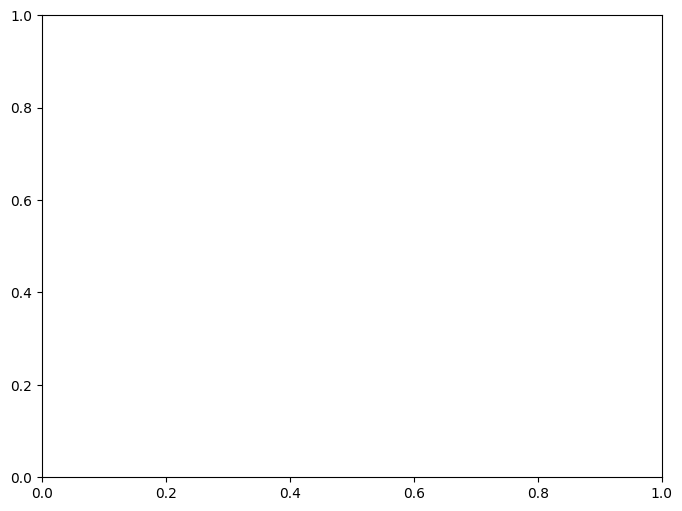

In [22]:
import matplotlib.pyplot as plt

# Iterate over unique meter values
for meter_value in building_predictions_df['meter_value'].unique():
    # Filter data for the current meter value
    meter_data = building_predictions_df[building_predictions_df['meter_value'] == meter_value]

    # Plot predicted vs. actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(meter_data['actual_value'], meter_data['predicted_value'], alpha=0.5)

    # Add labels and title
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.title(f'Predicted vs. Actual for Meter Type: {meter_value}')

    # Add a diagonal line for reference
    plt.plot([min(meter_data['actual_value']), max(meter_data['actual_value'])],
             [min(meter_data['actual_value']), max(meter_data['actual_value'])], color='red')

    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


29565